In [1]:
!cp -r ../input/d/romanofrancesco/recsys-repo/RecSys_Course_AT_PoliMi-master/* ./

In [2]:
%config Completer.use_jedi = False
import pandas as pd
import numpy as np
import scipy.sparse as sps
import matplotlib.pyplot as pyplot
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

In [3]:
#load data_train, matrix of users interaction
URM_path = "../input/recommender-system-2021-challenge-polimi/data_train.csv"
URM_all_dataframe = pd.read_csv(filepath_or_buffer=URM_path, 
                                sep=",",
                                dtype={0:int, 1:int, 2:float},
                                header=0)
URM_all_dataframe.columns = ["UserID", "ItemID", "Interaction"]

In [4]:
URM_all_dataframe.head()

,UserID,ItemID,Interaction
0,0,53,1.0
1,0,209,1.0
2,0,223,1.0
3,0,249,1.0
4,0,435,1.0


In [5]:
userID_unique = URM_all_dataframe["UserID"].unique()
itemID_unique = URM_all_dataframe["ItemID"].unique()

n_users = len(userID_unique)
n_items = len(itemID_unique)
n_interactions = len(URM_all_dataframe)

print ("Number of items\t {}, Number of users\t {}".format(n_items, n_users))
print ("Max ID items\t {}, Max Id users\t {}\n".format(max(itemID_unique), max(userID_unique)))
print ("Average interactions per user {:.2f}".format(n_interactions/n_users))
print ("Average interactions per item {:.2f}\n".format(n_interactions/n_items))

print ("Sparsity {:.2f} %".format((1-float(n_interactions)/(n_items*n_users))*100))

Number of items	 18059, Number of users	 13650
Max ID items	 18058, Max Id users	 13649

Average interactions per user 387.23
Average interactions per item 292.69

Sparsity 97.86 %


In [6]:
URM_all = sps.coo_matrix((URM_all_dataframe["Interaction"].values, 
                          (URM_all_dataframe["UserID"].values, URM_all_dataframe["ItemID"].values)))
URM_all = URM_all.tocsr() # to obtain fast access to rows (users)
URM_all

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 5285664 stored elements in Compressed Sparse Row format>

In [7]:
from Data_manager.split_functions.split_train_validation_random_holdout import split_train_in_two_percentage_global_sample

# split data into train and validation data 80/20
URM_train, URM_valid = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)

In [8]:
URM_train

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 4228531 stored elements in Compressed Sparse Row format>

In [9]:
URM_valid

<13650x18059 sparse matrix of type '<class 'numpy.float64'>'
	with 1057133 stored elements in Compressed Sparse Row format>

In [10]:
#Prepare ICM matrices for content based algos

ICM_genre_df = pd.read_csv("../input/recommender-system-2021-challenge-polimi/data_ICM_genre.csv")
ICM_genre_df

,row,col,data
0,0,3,1.0
1,1,3,1.0
2,2,6,1.0
3,3,0,1.0
4,3,1,1.0
...,...,...,...
17986,18055,3,1.0
17987,18056,2,1.0
17988,18056,3,1.0
17989,18057,3,1.0


In [11]:
items = ICM_genre_df.row
features = ICM_genre_df.col
data = ICM_genre_df.data
ICM_genre = sps.coo_matrix((data, (items, features)))
ICM_genre = ICM_genre.tocsr() #fast row (items) access
ICM_genre.shape

(18059, 8)

In [12]:
ICM_subgenre_df = pd.read_csv("../input/recommender-system-2021-challenge-polimi/data_ICM_subgenre.csv")
ICM_subgenre_df

,row,col,data
0,0,70,1.0
1,1,27,1.0
2,2,40,1.0
3,3,50,1.0
4,4,62,1.0
...,...,...,...
18052,18054,90,1.0
18053,18055,85,1.0
18054,18056,103,1.0
18055,18057,90,1.0


In [13]:
items = ICM_subgenre_df.row
features = ICM_subgenre_df.col
data = ICM_subgenre_df.data
ICM_subgenre = sps.coo_matrix((data, (items, features)))
ICM_subgenre = ICM_subgenre.tocsr() #fast row (items) access
ICM_subgenre.shape

(18059, 113)

In [14]:
# Concatenation of two ICM matrices
ICM_combined = sps.hstack((ICM_genre, ICM_subgenre))
ICM_combined.shape

(18059, 121)

In [15]:
from Evaluation.Evaluator import EvaluatorHoldout

#create an evaluator object to evaluate validation set
#we will use it for hyperparameter tuning
evaluator_valid = EvaluatorHoldout(URM_valid, cutoff_list=[10])

EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions


# Split users in groups and train multiple models

In [16]:
import numpy as np 
import scipy.sparse as sps

# count how many interactions each user has
profile_length = np.ediff1d(sps.csr_matrix(URM_train).indptr)
profile_length, profile_length.shape

(array([138, 477, 109, ..., 205, 146, 255], dtype=int32), (13650,))

In [17]:
# select 5% of users with least interactions
block_size = int(len(profile_length)*0.05)
block_size

682

In [18]:
sorted_users = np.argsort(profile_length)
sorted_users

array([9335, 9021, 5660, ..., 1141, 8526,  317])

In [19]:
# do the same for all users to obtain a division in 20 different groups of users
for group_id in range(0, 20):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))

Group 0, #users in group 682, average p.len 32.23, median 33.0, min 6, max 54
Group 1, #users in group 682, average p.len 73.30, median 74.0, min 54, max 90
Group 2, #users in group 682, average p.len 105.06, median 105.5, min 90, max 119
Group 3, #users in group 682, average p.len 131.92, median 132.0, min 119, max 143
Group 4, #users in group 682, average p.len 154.67, median 154.0, min 144, max 165
Group 5, #users in group 682, average p.len 175.44, median 175.0, min 166, max 185
Group 6, #users in group 682, average p.len 195.56, median 195.0, min 185, max 206
Group 7, #users in group 682, average p.len 217.31, median 217.0, min 206, max 229
Group 8, #users in group 682, average p.len 239.81, median 240.0, min 229, max 251
Group 9, #users in group 682, average p.len 261.94, median 262.0, min 251, max 272
Group 10, #users in group 682, average p.len 282.68, median 282.0, min 272, max 294
Group 11, #users in group 682, average p.len 306.40, median 306.0, min 294, max 319
Group 12, #u

In [20]:
import numpy as np
import scipy.sparse as sps
from Recommenders.Recommender_utils import check_matrix
from sklearn.linear_model import ElasticNet
from Recommenders.BaseSimilarityMatrixRecommender import BaseItemSimilarityMatrixRecommender
from Utils.seconds_to_biggest_unit import seconds_to_biggest_unit
import time, sys
from tqdm import tqdm
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

# os.environ["PYTHONWARNINGS"] = ('ignore::exceptions.ConvergenceWarning:sklearn.linear_model')
# os.environ["PYTHONWARNINGS"] = ('ignore:Objective did not converge:ConvergenceWarning:')

class SLIMElasticNetRecommender(BaseItemSimilarityMatrixRecommender):
    """
    Train a Sparse Linear Methods (SLIM) item similarity model.
    NOTE: ElasticNet solver is parallel, a single intance of SLIM_ElasticNet will
          make use of half the cores available
    See:
        Efficient Top-N Recommendation by Linear Regression,
        M. Levy and K. Jack, LSRS workshop at RecSys 2013.
        SLIM: Sparse linear methods for top-n recommender systems,
        X. Ning and G. Karypis, ICDM 2011.
        http://glaros.dtc.umn.edu/gkhome/fetch/papers/SLIM2011icdm.pdf
    """

    RECOMMENDER_NAME = "SLIMElasticNetRecommender"

    def __init__(self, URM_train, verbose = True):
        super(SLIMElasticNetRecommender, self).__init__(URM_train, verbose = verbose)

    @ignore_warnings(category=ConvergenceWarning)
    def fit(self, l1_ratio=0.1, alpha = 1.0, positive_only=True, topK = 100,**earlystopping_kwargs):

        assert l1_ratio>= 0 and l1_ratio<=1, "{}: l1_ratio must be between 0 and 1, provided value was {}".format(self.RECOMMENDER_NAME, l1_ratio)

        self.l1_ratio = l1_ratio
        self.positive_only = positive_only
        self.topK = topK


        # initialize the ElasticNet model
        self.model = ElasticNet(alpha=alpha,
                                l1_ratio=self.l1_ratio,
                                positive=self.positive_only,
                                fit_intercept=False,
                                copy_X=False,
                                precompute=True,
                                selection='random',
                                max_iter=100,
                                tol=1e-4)

        URM_train = check_matrix(self.URM_train, 'csc', dtype=np.float32)

        n_items = URM_train.shape[1]

        # Use array as it reduces memory requirements compared to lists
        dataBlock = 10000000

        rows = np.zeros(dataBlock, dtype=np.int32)
        cols = np.zeros(dataBlock, dtype=np.int32)
        values = np.zeros(dataBlock, dtype=np.float32)

        numCells = 0

        start_time = time.time()
        start_time_printBatch = start_time

        # fit each item's factors sequentially (not in parallel)
        for currentItem in range(n_items):

            # get the target column
            y = URM_train[:, currentItem].toarray()

            # set the j-th column of X to zero
            start_pos = URM_train.indptr[currentItem]
            end_pos = URM_train.indptr[currentItem + 1]

            current_item_data_backup = URM_train.data[start_pos: end_pos].copy()
            URM_train.data[start_pos: end_pos] = 0.0

            # fit one ElasticNet model per column
            self.model.fit(URM_train, y)

            # self.model.coef_ contains the coefficient of the ElasticNet model
            # let's keep only the non-zero values

            # Select topK values
            # Sorting is done in three steps. Faster then plain np.argsort for higher number of items
            # - Partition the data to extract the set of relevant items
            # - Sort only the relevant items
            # - Get the original item index

            nonzero_model_coef_index = self.model.sparse_coef_.indices
            nonzero_model_coef_value = self.model.sparse_coef_.data

            local_topK = min(len(nonzero_model_coef_value)-1, self.topK)

            relevant_items_partition = (-nonzero_model_coef_value).argpartition(local_topK)[0:local_topK]
            relevant_items_partition_sorting = np.argsort(-nonzero_model_coef_value[relevant_items_partition])
            ranking = relevant_items_partition[relevant_items_partition_sorting]

            for index in range(len(ranking)):

                if numCells == len(rows):
                    rows = np.concatenate((rows, np.zeros(dataBlock, dtype=np.int32)))
                    cols = np.concatenate((cols, np.zeros(dataBlock, dtype=np.int32)))
                    values = np.concatenate((values, np.zeros(dataBlock, dtype=np.float32)))


                rows[numCells] = nonzero_model_coef_index[ranking[index]]
                cols[numCells] = currentItem
                values[numCells] = nonzero_model_coef_value[ranking[index]]

                numCells += 1

            # finally, replace the original values of the j-th column
            URM_train.data[start_pos:end_pos] = current_item_data_backup

            elapsed_time = time.time() - start_time
            new_time_value, new_time_unit = seconds_to_biggest_unit(elapsed_time)


            if time.time() - start_time_printBatch > 300 or currentItem == n_items-1:
                self._print("Processed {} ({:4.1f}%) in {:.2f} {}. Items per second: {:.2f}".format(
                    currentItem+1,
                    100.0* float(currentItem+1)/n_items,
                    new_time_value,
                    new_time_unit,
                    float(currentItem)/elapsed_time))

                sys.stdout.flush()
                sys.stderr.flush()

                start_time_printBatch = time.time()

        # generate the sparse weight matrix
        self.W_sparse = sps.csr_matrix((values[:numCells], (rows[:numCells], cols[:numCells])),
                                       shape=(n_items, n_items), dtype=np.float32)

In [21]:
import os

output_folder_path = "result_experiments/"

# If directory does not exist, create
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

In [22]:
import pyximport
pyximport.install()

(None, <pyximport.pyximport.PyxImporter at 0x7f95a5753f10>)

In [23]:
#prepare the environment to run Cython code
!python run_compile_all_cython.py

run_compile_all_cython: Found 10 Cython files in 4 folders...
run_compile_all_cython: All files will be compiled using your current python environment: '/opt/conda/bin/python'
Compiling [1/10]: MatrixFactorization_Cython_Epoch.pyx... 
In file included from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarraytypes.h:1822,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/arrayobject.h:4,
                 from MatrixFactorization_Cython_Epoch.c:620:
/opt/conda/lib/python3.7/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~
MatrixFactorization_Cython_Epoch.c: In function ‘__pyx_pf_32MatrixFactorization_Cyth

In [24]:
#here we will save MAPs of different user groups
MAP_recommender_per_group = {}

#here we will save pairs label : recommnder_object
recommender_object_dict = {}

In [25]:
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender

mf_ials = IALSRecommender(URM_train)
mf_ials.fit(num_factors = 31, confidence_scaling= 'log',alpha = 0.0024941846820976015, epsilon = 3.449297756742473, reg = 5.61162089901928e-05, epochs = 40)
recommender_object_dict["MF_IALS"] = mf_ials

IALSRecommender: Epoch 1 of 40. Elapsed time 10.56 sec
IALSRecommender: Epoch 2 of 40. Elapsed time 22.21 sec
IALSRecommender: Epoch 3 of 40. Elapsed time 32.32 sec
IALSRecommender: Epoch 4 of 40. Elapsed time 42.77 sec
IALSRecommender: Epoch 5 of 40. Elapsed time 54.59 sec
IALSRecommender: Epoch 6 of 40. Elapsed time 1.08 min
IALSRecommender: Epoch 7 of 40. Elapsed time 1.26 min
IALSRecommender: Epoch 8 of 40. Elapsed time 1.45 min
IALSRecommender: Epoch 9 of 40. Elapsed time 1.63 min
IALSRecommender: Epoch 10 of 40. Elapsed time 1.81 min
IALSRecommender: Epoch 11 of 40. Elapsed time 2.00 min
IALSRecommender: Epoch 12 of 40. Elapsed time 2.17 min
IALSRecommender: Epoch 13 of 40. Elapsed time 2.34 min
IALSRecommender: Epoch 14 of 40. Elapsed time 2.53 min
IALSRecommender: Epoch 15 of 40. Elapsed time 2.70 min
IALSRecommender: Epoch 16 of 40. Elapsed time 2.87 min
IALSRecommender: Epoch 17 of 40. Elapsed time 3.04 min
IALSRecommender: Epoch 18 of 40. Elapsed time 3.24 min
IALSRecommende

In [26]:
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender

pure_svd = PureSVDRecommender(URM_train)
pure_svd.fit(num_factors=40)
recommender_object_dict["PURE_SVD"] = pure_svd

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.85 sec


In [27]:
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender

itemknn_cf = ItemKNNCFRecommender(URM_train)
itemknn_cf.fit(topK = 157, shrink = 463, similarity = 'cosine', normalize = True, feature_weighting = 'TF-IDF')
recommender_object_dict["ItemKNNCF"] = itemknn_cf

Similarity column 18059 (100.0%), 1148.57 column/sec. Elapsed time 15.72 sec


In [28]:
from Recommenders.KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender

itemknn_cbf = ItemKNNCBFRecommender(URM_train, ICM_combined)
itemknn_cbf.fit(topK = 41, shrink = 1000, similarity = 'cosine', normalize = True, feature_weighting = 'TF-IDF')
recommender_object_dict["ItemKNNCBF"] = itemknn_cbf

ItemKNNCBFRecommender: ICM Detected 13 ( 0.1%) items with no features.
Similarity column 18059 (100.0%), 4411.32 column/sec. Elapsed time 4.09 sec


In [29]:
slim_en = SLIMElasticNetRecommender(URM_train)
slim_en.fit(epochs = 500, l1_ratio = 0.0023170159712850467, alpha = 0.09078974149197175, positive_only = True, topK = 363)
recommender_object_dict["SLIM_EN"] = slim_en

SLIMElasticNetRecommender: Processed 1425 ( 7.9%) in 5.00 min. Items per second: 4.75
SLIMElasticNetRecommender: Processed 2834 (15.7%) in 10.00 min. Items per second: 4.72
SLIMElasticNetRecommender: Processed 4242 (23.5%) in 15.01 min. Items per second: 4.71
SLIMElasticNetRecommender: Processed 5610 (31.1%) in 20.01 min. Items per second: 4.67
SLIMElasticNetRecommender: Processed 7015 (38.8%) in 25.01 min. Items per second: 4.67
SLIMElasticNetRecommender: Processed 8434 (46.7%) in 30.01 min. Items per second: 4.68
SLIMElasticNetRecommender: Processed 9885 (54.7%) in 35.01 min. Items per second: 4.71
SLIMElasticNetRecommender: Processed 11397 (63.1%) in 40.01 min. Items per second: 4.75
SLIMElasticNetRecommender: Processed 12871 (71.3%) in 45.01 min. Items per second: 4.77
SLIMElasticNetRecommender: Processed 14226 (78.8%) in 50.02 min. Items per second: 4.74
SLIMElasticNetRecommender: Processed 15640 (86.6%) in 55.02 min. Items per second: 4.74
SLIMElasticNetRecommender: Processed 170

In [30]:
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython_Epoch import MatrixFactorization_Cython_Epoch
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython

slim_bpr = SLIM_BPR_Cython(URM_train)
slim_bpr.fit(epochs=650, sgd_mode = "sgd", topK = 483, lambda_i = 0.0006712905081189398, lambda_j = 0.06584150350451998, learning_rate = 0.0036482363905043207)
recommender_object_dict["SLIM_BPR"] = slim_bpr

SLIM_BPR_Recommender: Automatic selection of fastest train mode. Available RAM is 16461.00 MB (91.44%) of 18001.00 MB, required is 1304.51 MB. Using dense matrix.
Processed 13650 (100.0%) in 0.89 sec. BPR loss is 2.78E-01. Sample per second: 15299
SLIM_BPR_Recommender: Epoch 1 of 650. Elapsed time 0.70 sec
Processed 13650 (100.0%) in 1.48 sec. BPR loss is 1.06E+00. Sample per second: 9219
SLIM_BPR_Recommender: Epoch 2 of 650. Elapsed time 1.29 sec
Processed 13650 (100.0%) in 1.14 sec. BPR loss is 1.86E+00. Sample per second: 11945
SLIM_BPR_Recommender: Epoch 3 of 650. Elapsed time 1.95 sec
Processed 13650 (100.0%) in 0.82 sec. BPR loss is 2.67E+00. Sample per second: 16621
SLIM_BPR_Recommender: Epoch 4 of 650. Elapsed time 2.63 sec
Processed 13650 (100.0%) in 1.38 sec. BPR loss is 3.36E+00. Sample per second: 9879
SLIM_BPR_Recommender: Epoch 5 of 650. Elapsed time 3.19 sec
Processed 13650 (100.0%) in 0.99 sec. BPR loss is 4.01E+00. Sample per second: 13740
SLIM_BPR_Recommender: Epoch 6

In [31]:
from Recommenders.NonPersonalizedRecommender import TopPop

top_pop = TopPop(URM_train)
top_pop.fit()
recommender_object_dict["TOP_POP"] = top_pop

# Plot results of models for different users groups

In [32]:
# here we perform validation over different user groups for each model
# then we plot a graph to compare them
cutoff = 10

for group_id in range(0, 20):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_validation = EvaluatorHoldout(URM_valid, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_validation.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]

Group 0, #users in group 682, average p.len 32.23, median 33.0, min 6, max 54
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 677 (100.0%) in 2.22 sec. Users per second: 305
EvaluatorHoldout: Processed 677 (100.0%) in 2.03 sec. Users per second: 334
EvaluatorHoldout: Processed 677 (100.0%) in 2.26 sec. Users per second: 300
EvaluatorHoldout: Processed 677 (100.0%) in 1.87 sec. Users per second: 361
EvaluatorHoldout: Processed 677 (100.0%) in 1.87 sec. Users per second: 361
EvaluatorHoldout: Processed 677 (100.0%) in 1.84 sec. Users per second: 367
EvaluatorHoldout: Processed 677 (100.0%) in 1.93 sec. Users per second: 350
Group 1, #users in group 682, average p.len 73.30, median 74.0, min 54, max 90
EvaluatorHoldout: Ignoring 13645 ( 0.0%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 12968 Users
EvaluatorHoldout: Processed 682 (100.0%) in 2.07 sec. Users

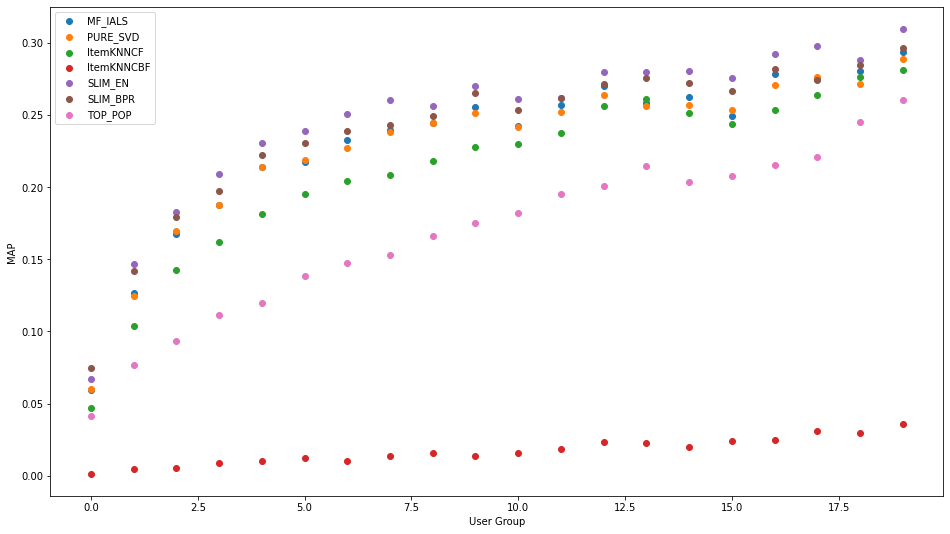

In [33]:
import matplotlib.pyplot as plt
%matplotlib inline  

_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0,len(results)), y=results, label=label)
plt.ylabel('MAP')
plt.xlabel('User Group')
plt.legend()
plt.show()

# Create final recommandations

In [34]:
#test_users = pd.read_csv('../input/recommender-system-2021-challenge-polimi/data_target_users_test.csv')
#test_users

In [35]:
#user_id = test_users['user_id']
#recommendations = []
#for user in user_id:
    #recommendations.append(recommender.recommend(user,cutoff = 10))

In [36]:
#for index in range(len(recommendations)):
    #recommendations[index]=np.array(recommendations[index])
    
#test_users['item_list']= recommendations
#test_users['item_list'] = pd.DataFrame([str(line).strip('[').strip(']').replace("'","") for line in test_users['item_list']])
#test_users.to_csv('submission.csv', index=False)